## Baselines for optimal transport

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
from plotnine import *
import os
from sklearn.metrics import r2_score, f1_score
from sklearn.metrics.pairwise import paired_distances

### Load the data

In [2]:
path = "/p/project1/hai_fzj_bda/koenig8/ot/data/"
adata_st = sc.read_h5ad(os.path.join(path, "adata_st.h5ad"))
adata_histo = sc.read_h5ad(os.path.join(path, "adata_histo.h5ad"))
adata_histo = adata_histo[adata_histo.obs.in_sample]  # Sample down
adata_st, adata_histo 

(AnnData object with n_obs × n_vars = 50000 × 50
     obs: 'patch_id', 'brain_area', 'patchsize', 'x_st', 'y_st', 'z_st', 'brain_section_label', 'section', 'test_set', 'val_set', 'train_set'
     uns: 'neighbors', 'umap'
     obsm: 'X_umap', 'brain_area_onehot', 'brain_area_similarities', 'pca_embedding', 'pca_plus_slides', 'pca_plus_slides_scaled'
     obsp: 'connectivities', 'distances',
 View of AnnData object with n_obs × n_vars = 50000 × 1536
     obs: 'image_id', 'patchsize', 'center_ccf', 'pixel_coord', 'distance', 'nearest_ST', 'nearest_cell_id', 'target_atlas_plate', 'distance_new', 'x', 'y', 'z', 'x_st', 'y_st', 'z_st', 'image_nr', 'brain_area', 'group', 'slice', 'in_sample', 'test_set', 'val_set', 'train_set'
     obsm: 'brain_area_onehot', 'brain_area_similarities', 'uni_embedding', 'uni_pca_95', 'uni_pca_plus_coords')

## First baseline: random assignment

In [3]:
st_points = adata_st.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()
histo_points = adata_histo.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()
st_area = adata_st.obs.brain_area.to_numpy()
histo_area = adata_histo.obs.brain_area.to_numpy()

def eval_translation(ind, ad_src=adata_st, ad_target=adata_histo):
    st_points = ad_src.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()
    histo_points = ad_target.obs.loc[:, ('x_st', 'y_st', 'z_st')].to_numpy()
    st_area = ad_src.obs.brain_area.to_numpy()
    histo_area = ad_target.obs.brain_area.to_numpy()
    
    coords_pred = histo_points[ind]
    area_pred = histo_area[ind]

    r2 = r2_score(st_points, coords_pred)
    f1 = f1_score(st_area, area_pred, average="weighted")
    dist = np.mean(paired_distances(st_points, coords_pred, metric="euclidean"))
    return pd.DataFrame([dist, r2, f1], 
                        index=("Distance to actual in µm", "R² coordinates", "Brain area weighted f1"),
                        columns = ["Score",])

In [4]:
rng = np.random.default_rng(seed=352)
random_ind = rng.choice(list(range(adata_histo.shape[0])), size=adata_st.shape[0], replace = False)
random = eval_translation(random_ind)
random

,Score
Distance to actual in µm,4.752129
R² coordinates,-1.068765
Brain area weighted f1,0.207411


## Second baseline: assignment by brain area

In [5]:
area_ind = np.zeros(st_area.shape[0]).astype(int).flatten()
for brain_area in np.unique(st_area):
    st_ind = np.argwhere(st_area == brain_area).flatten()
    n = len(st_ind)
    histo_ind = np.argwhere(histo_area == brain_area).flatten()
    if len(histo_ind) > 0:
        ind_random = rng.choice(histo_ind, size = n, replace=True)
    else:
        # No equivalent in histo
        ind_random = rng.choice(list(range(adata_histo.shape[0])), size = n, replace=True)
        print(f"no equivalent for {brain_area}")
    area_ind[st_ind] = ind_random
    
print((histo_area[area_ind] == st_area).sum() / 50000)

no equivalent for MY
no equivalent for P
0.96024


In [6]:
(area_ind == 0).sum()

np.int64(0)

In [7]:
area_trans = eval_translation(area_ind)
area_trans

,Score
Distance to actual in µm,3.377927
R² coordinates,-0.309617
Brain area weighted f1,0.943155


## Third baseline: use brain area and the st coordinates
For this assume that all slides are perfectly cut (no variance along x-axis)

In [8]:
area_ind = np.zeros(st_area.shape[0]).astype(int).flatten()
for brain_area in np.unique(st_area):
    st_ind = np.argwhere(st_area == brain_area).flatten()
    n = len(st_ind)
    histo_ind = np.argwhere(histo_area == brain_area).flatten()
    if len(histo_ind) > 0:
        ind_random = rng.choice(histo_ind, size = n, replace=True)
    else:
        # No equivalent in histo
        ind_random = rng.choice(list(range(adata_histo.shape[0])), size = n, replace=True)
        print(f"no equivalent for {brain_area}")
    area_ind[st_ind] = ind_random
    


no equivalent for MY
no equivalent for P


## Best ot model

In [6]:
ff = pd.DataFrame(
    [-1.068765, -0.309617, 0.2067, -0.128173039, -0.0644], 
    index=("Random", "Random + brain area", "Optimal Transport", "SimCLR", "SupCon"),
    columns = ("R²",)
)
ff = ff.reset_index(names="model")
ff

,model,R²
0,Random,-1.068765
1,Random + brain area,-0.309617
2,Optimal Transport,0.206700
3,SimCLR,-0.128173
4,SupCon,-0.064400


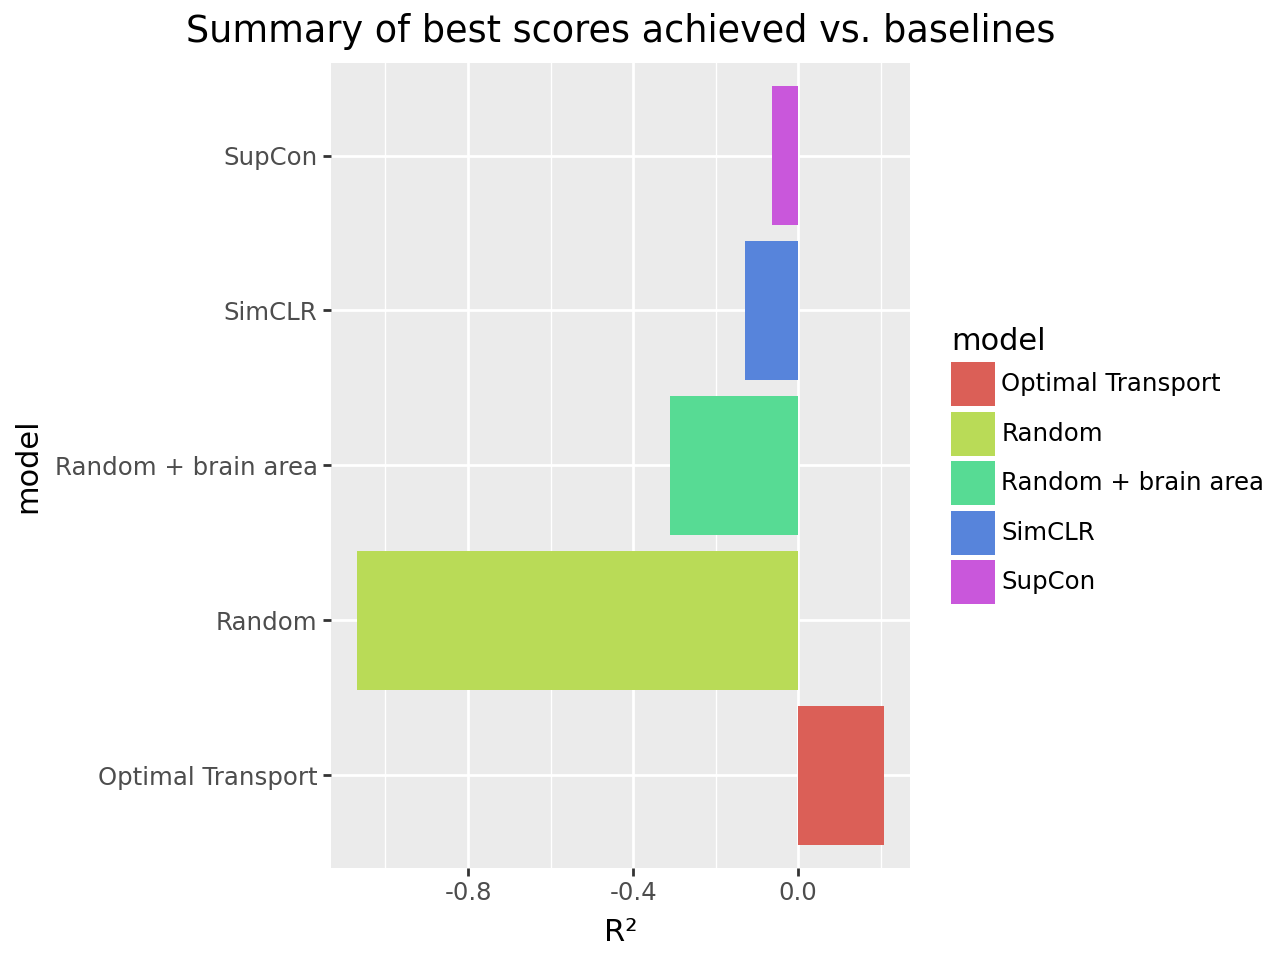

In [10]:
plot =(
    ggplot(ff, aes(x="model", y="R²", fill = "model")) + 
    geom_bar(stat="identity") +
    coord_flip() +
    ggtitle("Summary of best scores achieved vs. baselines")
)
plot